In [1]:
#default_exp estimators

In [2]:
#hide
from nbdev.showdoc import *

%load_ext autoreload
%autoreload 2 #autoreload to make code from other modules get updated online inside notebook

import sys
sys.path.append('..') #appends project root to path in order to import project packages since `noteboks_dev` is not on the root

#DO NOT EDIT

# Code

In [3]:
#export
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm

from fkausality.kernel import JaccardForestKernel
from fkausality.utils import hstack, vstack
from fkausality.dist import sample_from_neighbors_continuous

In [4]:
#data for evaluation
from fklearn.data.datasets import make_confounded_data
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [5]:
df_rnd, df_obs, df_cf = make_confounded_data(10000)
#calculate treament effect based on counterfactuals
t_effets = (df_obs['recovery'] - df_cf['recovery'])*((-1)**df_cf['medication'])

df_obs['treatment_effect'] = t_effets
df_obs['cf_recovery'] = df_cf['recovery']

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


medication
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

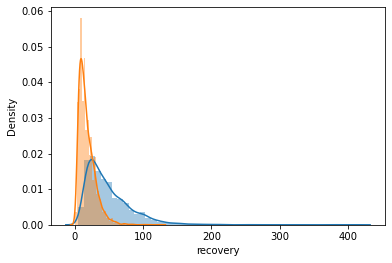

In [6]:
df_rnd.groupby('medication').apply(lambda x: sns.distplot(x['recovery']))

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


medication
0.0    AxesSubplot(0.125,0.125;0.775x0.755)
1.0    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

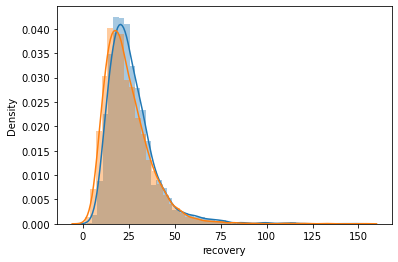

In [7]:
df_obs.groupby('medication').apply(lambda x: sns.distplot(x['recovery']))

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    10000.000000
mean       -30.144300
std         21.483287
min       -289.000000
25%        -40.000000
50%        -25.000000
75%        -15.000000
max          5.000000
Name: treatment_effect, dtype: float64

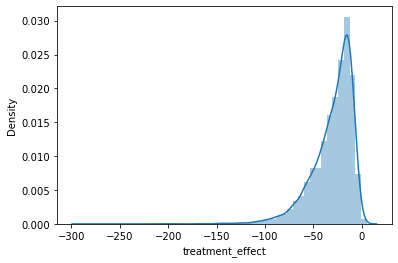

In [8]:
#We can see that the treatment effect can have a negative effect (positive recovery time) in very few cases

sns.distplot(df_obs['treatment_effect'])
df_obs['treatment_effect'].describe()

In [9]:
#export 


class SMFormulaWrapper(BaseEstimator, RegressorMixin):
    """ 
    A sklearn-style wrapper for formula-based statsmodels regressors,
    thanks to https://nelsonauner.com/data/2018/05/21/wrap-statsmodels-in-sklearn.html
    """
    def __init__(self, model_class, formula):
        self.model_class = model_class
        self.formula = formula
    def fit(self, X, y=None):
        self.model_ = self.model_class(self.formula, data=X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        return self.results_.predict(X)
    
class SMWrapper(BaseEstimator, RegressorMixin):
    """ 
    A universal sklearn-style wrapper for statsmodels regressors ,
    thanks to https://stackoverflow.com/questions/41045752/using-statsmodel-estimations-with-scikit-learn-cross-validation-is-it-possible/
    """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [10]:
class _FKEstimator(BaseEstimator):
    
    def __init__(
        self,
        tree_ensemble_estimator,
        #pointwise variance args
        pointwise_variance_dist = 'normal',
        pointwise_variance_alpha = 1,
        pointwise_variance_min_var = 1e-2,
        #knn index args
        n_neighbors=30,
        index_time_params={'M': 30, 'indexThreadQty': 4, 'efConstruction': 100, 'post': 0},
        query_time_params={'efSearch': 100},     
        
    ):
        
        #tree estimator
        self.tree_ensemble_estimator = tree_ensemble_estimator
        #pointiwse variance for sampling
        self.pointwise_variance_dist = pointwise_variance_dist
        self.pointwise_variance_alpha = pointwise_variance_alpha
        self.pointwise_variance_min_var = pointwise_variance_min_var
        #knn indexing
        self.n_neighbors = n_neighbors
        self.index_time_params = index_time_params
        self.query_time_params = query_time_params
        return
        
    def fit(self, X, y = None, T = None, save_values = None, **kwargs):        
        
        #fit matching forest estimator
        self.forest_estimator_kernel = JaccardForestKernel(
            estimator=self.tree_ensemble_estimator,
            n_neighbors=self.n_neighbors,
            index_time_params=self.index_time_params,
            query_time_params=self.query_time_params,
        )
                                
        #handle save values
        if not save_values is None:
            if not hasattr(save_values, 'columns'):
                if save_values.ndim == 1:
                    save_values = save_values.reshape(-1,1)                
                else:
                    pass
                save_values_columns_ = [f'saved_value_{i}' for i in range(y.shape[-1])]
            else:
                save_values_columns_ = list(save_values.columns)
        else:
            self.save_values_columns_ = []
            save_values = np.empty((y.shape[0], 0), )
                    
        #handle y saving
        if not hasattr(y, 'columns'):
            if y.ndim == 1:
                y = y.reshape(-1,1)        
            else:
                pass
            y_columns_ = [f'target_{i}' for i in range(y.shape[-1])]
        else:
            y_columns_ = list(y.columns)
        
        #handle T saving
        if not hasattr(T, 'columns'):
            if T.ndim == 1:
                T = T.reshape(-1,1)        
            else:
                pass
            T_columns_ = [f'treatment_{i}' for i in range(y.shape[-1])]
        else:
            T_columns_ = list(T.columns)
        
        #cast to array
        save_values = np.array(save_values)
        y = np.array(y)
        T = np.array(T)
        #remove from save_values cols that are already in y or T
        all_save_columns = pd.Series(save_values_columns_ + T_columns_ + y_columns_)
        keep_cols_msk = (~all_save_columns.duplicated()).values
        all_save_columns = all_save_columns[keep_cols_msk].values.tolist()
        #hstack save_values to y and T
        save_values = hstack([save_values, T, y])[:, keep_cols_msk]
        
        self.forest_estimator_kernel.fit(X, y = T, save_values = save_values, **kwargs) #matching esstimator regress X on T
        
        self.saved_values_ = save_values
        self.save_values_columns_ = save_values_columns_
        self.T_columns_ = T_columns_
        self.y_columns_ = y_columns_
        self.all_saved_values_columns_ = all_save_columns
        return self
    
    def _saved_data_to_pandas(self, values):
        #list is returned from query, so we have to iterate                
        return [pd.DataFrame(v, columns = self.all_saved_values_columns_) for v in values]
    
    def kneighbors(self, X = None, n_neighbors = None, return_distance = False, query_from = None):
        if not query_from is None:
            params = self.forest_estimator_kernel.nearest_neighbors_estimator.get_params()
            klass = self.forest_estimator_kernel.nearest_neighbors_estimator.__class__
            knn_estim = klass(**params).fit(X)
        else:
            knn_estim = self.forest_estimator_kernel        
            
        return knn_estim.kneighbors(X = X, n_neighbors = n_neighbors, return_distance = return_distance)
    
    def query(self, X = None, n_neighbors = None, precomputed_neighbors = None):
        '''
        queries similar datapoints and returns saved_data from queried indexes, alongside
        jaccard dissimilarity
        '''
        
        if precomputed_neighbors is None:
            precomputed_neighbors = self.kneighbors(X = X, n_neighbors = n_neighbors, return_distance=True)
        
        dsts, nbrs_idxs = precomputed_neighbors
        values = [self.saved_values_[i] for i in nbrs_idxs]
        values = self._saved_data_to_pandas(values)
        values = [values[i].assign(dissimilarity = dsts[i]) for i in range(len(values))]
        return values    


In [11]:
class FKDiscreteEstimator():
    pass

In [12]:
def debug_args(func, argstoprint = None):
    def wrapped(**kwargs):        
        if not argstoprint is None:
            for arg in argstoprint:
                print(arg, kwawrgs[arg])
        else:
            print(kwargs)
        return func(**kwargs)
    return wrapped

class CEDTstimator(_FKEstimator):
    '''
    Continuous Effect - Discrete Treatmet estimator
    '''            
    def sample(
        self,
        X = None,
        n_neighbors = None,
        precomputed_neighbors = None,
        sample_size = 100,
        alpha = 1,
        noise_type = 'normal',
        variance_mapper='log',
        min_var_factor=0.01,
    ):
        '''
        samples target (y) according to pointwise_variance sampling strategy.
        if not stratify, samples are drawn randomly from neighbors
        '''
        
        queries = self.query(X, n_neighbors = n_neighbors, precomputed_neighbors = precomputed_neighbors)        
        sampled_dfs = []
        for q in queries:
            q = q.query('dissimilarity > 0') #get only cases where dissimilarity is greater than zero                        
            sampled_df = (
                q.groupby(self.T_columns_)
                .apply(
                    lambda df: sample_from_neighbors_continuous(
                        neighborhood_values = df[self.y_columns_].values,
                        jac_dists = df['dissimilarity'].values,
                        size = sample_size, 
                        alpha = alpha,
                        noise_type = noise_type,
                        variance_mapper=variance_mapper,
                        min_var_factor=min_var_factor,
                    )[0]
                )
            )
            sampled_df = pd.concat(sampled_df.apply(pd.DataFrame).to_dict())
            sampled_df.columns = self.y_columns_
            sampled_df = sampled_df.reset_index(level = -1, drop = True)
            sampled_df.index = sampled_df.index.set_names(tuple(self.T_columns_))
            sampled_dfs.append(sampled_df)
        
        return sampled_dfs
    
    def infer_cate(self, return_ci):
        '''
        infers conditional average treatment effect for each datapoint, taking the
        correlation between the target and the treatment in each neighborhood
        '''
        return    

In [13]:
class DECTEstimator(_FKEstimator):
    '''
    Discrete Effect - Continuous Treatmet estimator
    '''            
    pass

In [14]:
class DEDTEstimator(_FKEstimator):
    '''
    Discrete Effect - Discrete Treatmet estimator
    '''            
    pass

In [53]:
class CECTEstimator(_FKEstimator):
    '''
    Continuous Effect - Continuous Treatmet estimator
    '''            
    def sample(
        self,
        X = None,
        n_neighbors = None,
        precomputed_neighbors = None,
        sample_size = 100,
        alpha = 1,
        noise_type = 'normal',
        variance_mapper='log',
        min_var_factor=0.01,
    ):
        '''
        samples target (y) according to pointwise_variance sampling strategy.
        if not stratify, samples are drawn randomly from neighbors
        '''
        
        queries = self.query(X, n_neighbors = n_neighbors, precomputed_neighbors = precomputed_neighbors)        
        sampled_dfs = []
        for q in queries:
            q = q.query('dissimilarity > 0') #get only cases where dissimilarity is greater than zero                        
            sampled_values, sampled_idxs = sample_from_neighbors_continuous(                
                neighborhood_values = q[self.y_columns_].values,
                jac_dists = q['dissimilarity'].values,
                size = sample_size, 
                alpha = alpha,
                noise_type = noise_type,
                variance_mapper=variance_mapper,
                min_var_factor=min_var_factor,
            )
            
            
            sampled_df = pd.DataFrame(sampled_values)
            sampled_df.columns = self.y_columns_
            for col in self.T_columns_:
                sampled_df[col] = q[col].values[sampled_idxs]
            
            sampled_df = sampled_df.set_index(self.T_columns_)
            sampled_dfs.append(sampled_df)
        
        return sampled_dfs
    
    def infer_cate(self, X, return_var, return_ci = [0.05,0.95]):
        '''
        infers conditional average treatment effect for each datapoint, taking the
        correlation between the target and the treatment in each neighborhood
        '''
        return
    

In [61]:
Tc = ['medication']
Xc = ['sex','age','severity']
yc = ['recovery']

X = df_obs[Xc]
T = df_obs[Tc]
y = df_obs[yc]

In [62]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor

tree_estim = ExtraTreesRegressor(min_samples_leaf = 10)
estim = CECTEstimator(tree_estim, n_neighbors = 100).fit(X, y = y, T = T, save_values = df_obs)

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


medication
0.0    AxesSubplot(0.125,0.125;0.775x0.755)
1.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: recovery, dtype: object

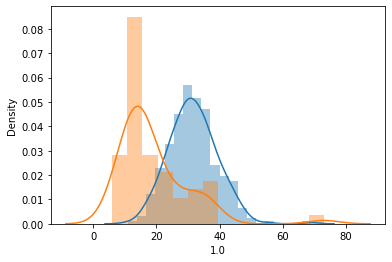

In [18]:
if not 'i' in locals():
    i = 0
i += 1 
ground_truth = df_obs.iloc[i]
query = estim.query(X.iloc[i:i+1], n_neighbors = 1000)[0].query('dissimilarity > 0')
query.groupby('medication')['recovery'].apply(sns.distplot)

In [25]:
query.groupby('medication')[['recovery','dissimilarity']].describe().T

medication                  0.0        1.0
recovery      count  246.000000  21.000000
              mean    25.378049  25.904762
              std      6.240696   9.888907
              min      9.000000   8.000000
              25%     21.000000  19.000000
              50%     25.000000  23.000000
              75%     30.000000  34.000000
              max     41.000000  47.000000
dissimilarity count  246.000000  21.000000
              mean     0.548386   0.943663
              std      0.184738   0.024606
              min      0.039216   0.876405
              25%      0.437500   0.941799
              50%      0.540146   0.958333
              75%      0.639456   0.958333
              max      0.958333   0.969072

In [26]:
alpha = 1
sampled_vals_nt, _ = sample_from_neighbors_continuous(
    query.query('medication == 0')[yc].values,
    query.query('medication == 0')['dissimilarity'].values,
    size = 1000, 
    alpha = alpha,
    noise_type = 'normal'
)

sampled_vals_t, _ = sample_from_neighbors_continuous(
    query.query('medication == 1')[yc].values,
    query.query('medication == 1')['dissimilarity'].values,
    size = 1000, 
    alpha = alpha,
    noise_type = 'normal'
)

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


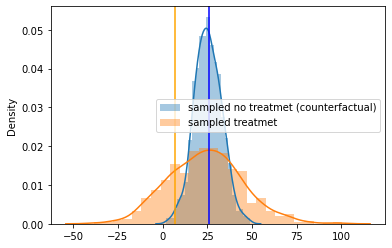

In [27]:
got_medication = ground_truth['medication'] == 1

t_recovery = ground_truth['recovery'] if got_medication else ground_truth['cf_recovery']
nt_recovery = ground_truth['recovery'] if not got_medication else ground_truth['cf_recovery']

nt_text = ' (counterfactual)' if got_medication else ''
t_text = ' (counterfactual)' if not got_medication else ''

sns.distplot(sampled_vals_nt, label = f'sampled no treatmet{t_text}')
sns.distplot(sampled_vals_t, label = f'sampled treatmet{nt_text}')

plt.axvline(nt_recovery, color = 'b')
plt.axvline(t_recovery, color = 'orange')


plt.legend()

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


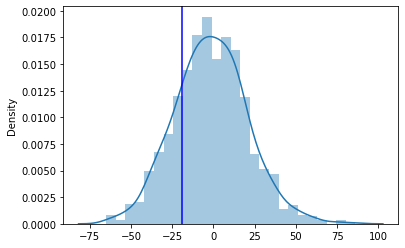

In [28]:
#Estimated traatment effect from sampling
real_t_effect = ground_truth['treatment_effect']
sns.distplot(sampled_vals_t - sampled_vals_nt)
plt.axvline(real_t_effect, color = 'b')

# Export -

In [20]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted dist-checkpoint.ipynb.
Converted estimators-checkpoint.ipynb.
Converted kernel-checkpoint.ipynb.
Converted neighbors-checkpoint.ipynb.
Converted dist.ipynb.
Converted estimators.ipynb.
Converted index.ipynb.
Converted kernel.ipynb.
Converted neighbors.ipynb.
Converted utils.ipynb.
